# NewYorker - Case Study for Senior Data Scientist

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-whitegrid")
from datetime import date

## 1. Pricing
> Our marketing manager was surveying the willingness to buy one of our fashion items at a certain price. They discovered the demand quantities, i.e. the number of people willing to buy, at various price levels. We have them below in two arrays.

In [2]:
pricing = pd.DataFrame({
'prices': [100, 90, 70, 60, 40, 20, 10],
'demand': [100, 120, 200, 300, 1200, 2000, 2800] })

> **Please find out the optimal price that maximises revenue.**    

Considering that no specific details on the relationship between prices and demand have been given, I am going to assume that the revenue is simply calculated by the product between these two quantities. I am also going to assume that we are talking of prices in euros, for completeness.  

In [3]:
### Uncomment the block below to plot the revenue curve as a function of price.

# fig,ax = plt.subplots(figsize=(7,4))
# plt.scatter(x=pricing.prices,y=pricing.prices*pricing.demand)
# plt.xlabel('Price (euros)',fontsize=16)
# plt.ylabel('Revenue (euros)',fontsize=16)
# plt.title('Revenue curve in function of the item price',fontsize=16)
# plt.show()

In [4]:
### Uncomment the block below to plot the price vs demand curve.

# fig,ax = plt.subplots(figsize=(7,4))
# plt.scatter(x=pricing.demand,y=pricing.prices)
# plt.ylabel('Price (euros)',fontsize=16)
# plt.xlabel('Demand',fontsize=16)
# plt.title('')
# plt.show()

In [5]:
def calculate_revenue(prices, demand):
    
    if prices.isnull().values.any() or (prices == 0).any():
        return ValueError('The prices argument contains nulls or zeros.')
    if demand.isnull().values.any():
        return ValueError('The demand argument contains nulls.')
    if (demand == 0).any():
        print('>>> WARNING: The demand argument contains zeros. Is this correct? <<<')
    
    return prices * demand

In [6]:
def revenue_maximizing_price(prices, demand): 
    """
    This function calculates the optimal price to maximize the revenue, 
    given two pandas Series as input arguments.
    Arguments:
    :prices: list of the prices of the product of interest.
    :demand: list of the quantity of product bought at a certain price.
    """
        
    revenue = calculate_revenue(prices, demand)
    optimal_price = prices.loc[revenue.idxmax()]
    
    return print(f"\nThe optimal price that maximize revenue is {optimal_price} euros.\n")

In [7]:
revenue_maximizing_price(pricing.prices, pricing.demand)


The optimal price that maximize revenue is 40 euros.



----
> The supplier for this particular fashion item has applied progressive discounting on their price. This means that quantities of the item above a certain value cost progressively less than the initial quantities. This is their pricing table:  

| quantity | supplier price |   
|:-----------|-----------------:|   
| <= 50 | 15 | 
|51-100 | 12 | 
|101-200 | 8| 
|>200 | 4|  

> **Knowing the demand (from the previous question) and the supplier price, and assuming that the only costs we have are the cost of the goods we sell, please find the price that maximizes our profits.**

In [8]:
def profit_maximizing_price(selling_price, demand): 
    """
    This function calculates the optimal price to maximize profit, 
    given, as input arguments, two pandas Series.
    Arguments:
    :selling_price: list of the prices of the product of interest.
    :demand: list of the quantity of product bought at a certain price.
    """  
    supplier_price = [] 
    for q in demand:
        if q <= 50:
            supplier_price.append(15)
        elif q > 50 and q <=100:
            supplier_price.append(12)
        elif q > 100 and q <=200:
            supplier_price.append(8)
        else:
            supplier_price.append(4)
            
    # calculate the revenue, cost and profit
    revenue = calculate_revenue(selling_price, demand)
    cost    = demand * supplier_price
    profit  = revenue - cost
    
    # retrieve the optimal price using the index of the max profit
    optimal_price = selling_price.loc[profit.idxmax()]
    
    return  print(f"\nThe optimal price that maximize profit is {optimal_price} euros.\n")

In [9]:
profit_maximizing_price(pricing.prices, pricing.demand)


The optimal price that maximize profit is 40 euros.



----
## Regression
> In the attached file `sales.csv` there is weekly sales of individual product types.  

In [10]:
sales = pd.read_csv('sales.csv')
sales.date = pd.to_datetime(sales.date)
sales = sales.set_index('date').sort_index()
sales = sales[sales.sum().sort_values(ascending=False).index]
round(sales.describe().loc[['mean','min','max']],1)

,Dress,T-shirt,Blouse,Shorts,Skirt,Jacket,Hoodie
mean,31115.6,21097.8,14372.9,11146.9,8951.9,5675.1,4555.5
min,14134.0,6277.0,6718.0,1001.0,5010.0,2405.0,825.0
max,91052.0,49272.0,35598.0,63788.0,21842.0,14411.0,12696.0


After confirming that there are no null values in the dataset (with `sales.isna().sum()`), we plot the time series of the total weekly sales (here, below) and for each item separately (further below). The distibutions of the separate products are ordered by total number of sales, in descending order.    

In [11]:
total_sales = 0
for i in sales.columns:
    total_sales += sales[i].groupby('date').sum()
total_sales.name = 'Total Sales'

round(total_sales.describe().loc[['mean','min','max']],1)

mean     96915.7
min      50151.0
max     268214.0
Name: Total Sales, dtype: float64

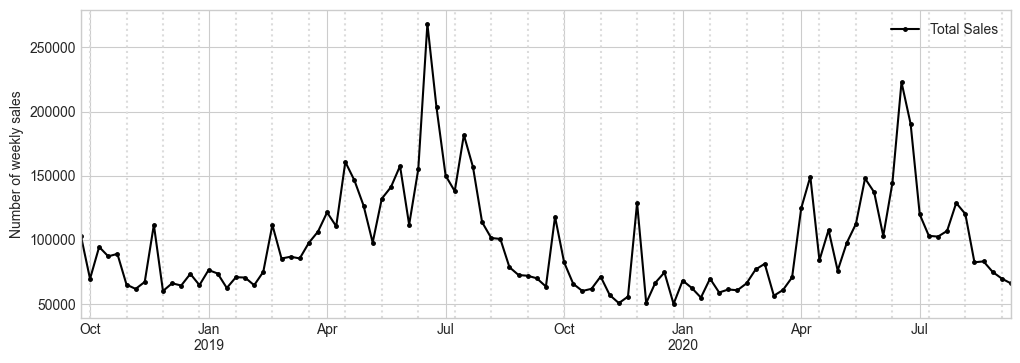

In [12]:
fig,ax = plt.subplots(figsize=(12,4))

total_sales.plot(ax=ax,marker='o',ms=2.5,color='k')
for m in np.arange(1,104, 4):    
    plt.axvline(sales.index[m],color='gainsboro',linestyle=':',zorder=1)
# ax.xaxis.grid(False)    
plt.xlabel('')
plt.ylabel('Number of weekly sales')
plt.title('')
plt.legend()
plt.show()

> **a1. What can be said about the overall trend and seasonality of sales?**   

The **trend** is defined as the long-term change (increase or decrease) in the data of a time-series.   
Just by looking at the plotted distribution, considering points at one year distance (e.g. 1st of July 2019 and 1st of July 2020), we could observe the overall weekly sales have a decreasing trend. These conclusions can be confirmed by running a season-trend decomposition. I choose the [LOESS](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.STL.html#statsmodels.tsa.seasonal.STL) decomposition from the `statsmodels` library.  

In [13]:
from statsmodels.tsa.seasonal import STL
colors =['red','darkorange','gold','forestgreen','lightskyblue','royalblue','mediumorchid']

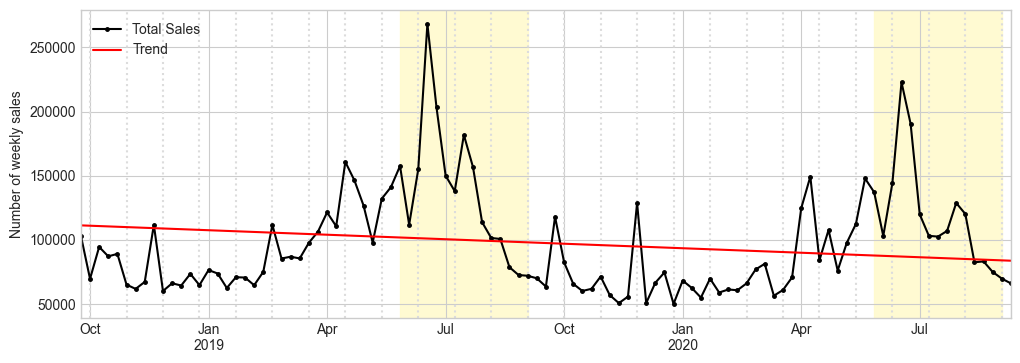

In [14]:
decomp_total = STL(total_sales).fit()

fig,ax = plt.subplots(figsize=(12,4))

decomp_total.observed.plot(ax=ax,marker='o',ms=2.5,color='k')
decomp_total.trend.plot(ax=ax, color='red',label='Trend')
for m in np.arange(1,104, 4):    
    plt.axvline(sales.index[m],color='gainsboro',linestyle=':',zorder=1)
# ax.xaxis.grid(False) 
plt.axvspan('2019-05-30', '2019-09-05', color='lemonchiffon', alpha=0.9, zorder=0)
plt.axvspan('2020-05-28', '2020-09-03', color='lemonchiffon', alpha=0.9, zorder=0)

plt.xlabel('')
plt.ylabel('Number of weekly sales')
plt.title('')
plt.legend()
plt.show()

The **seasonality** describes the periodic nature of the data, which would indicate that the time-series is influenced by, for example, the time of the year. Indeed in the date we observe that there is a seasonality due to the part of the year considered, with higher sales in the summer months.     

> **a2. What of the individual product type?**    

Focusing on the individual product types we can observe that items that are specific of a season (jackets and hoodies in winter and shorts in summer) see an increase in sales mostly in the time period in which their are fitting pieces of clothing. The presence of off-season peak would need to be investigated further, but they could be attributed to sales (i.e. reduced prices) periods.  
Regarding the trend of each product, we observe that:
- dresses have a almost flat (constant) trend, sliglty increasing;
- skirts, jackets and hoodies have also almost flat trend, but slightly decreasing;
- t-shirts, blouses and shorts have a decreasing trend, stronger compared to the other products.

I would assume that a constant, or almost constant, trend is expected for clothing products, as people tend to buy new clothes, especially if fashion trends change. In this regard, I would investigate further why we instead observe a decreasing trend for t-shirts, blouses and shorts, that sets them apart from the otehr products.  

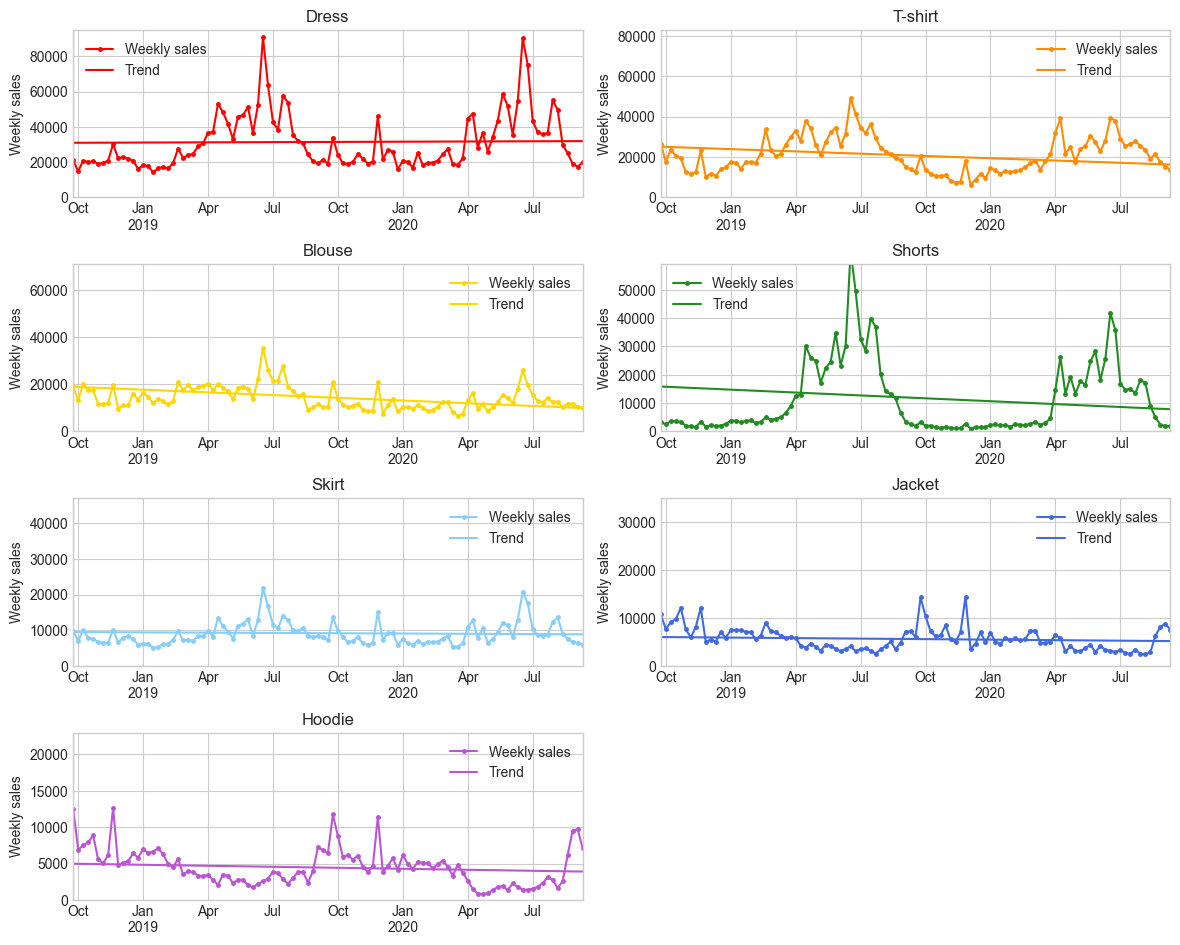

In [15]:
fig, axs = plt.subplots(len(sales.columns)//2+int(len(sales.columns)%2), 2, figsize=(12, 10))
axs = axs.reshape(-1)

decomp_products = []   
for i, (ax, product) in enumerate(zip(axs, sales.columns)): 
    decomp_products.append(STL(sales[product]).fit())
    decomp_products[i].observed.plot(ax=ax, marker='o',ms=2.5,color=colors[i],label='Weekly sales')
    decomp_products[i].trend.plot(ax=ax,color=colors[i],label='Trend')

    ax.set_title(f'{product}')
    ax.legend()
    ax.set_xlabel("")
    ax.set_ylabel("Weekly sales")
    ax.set_ylim(0,9.5e4-i*1.2e4)
     
fig.tight_layout()
fig.subplots_adjust(top=0.92)
plt.delaxes(axs[7])
plt.show()

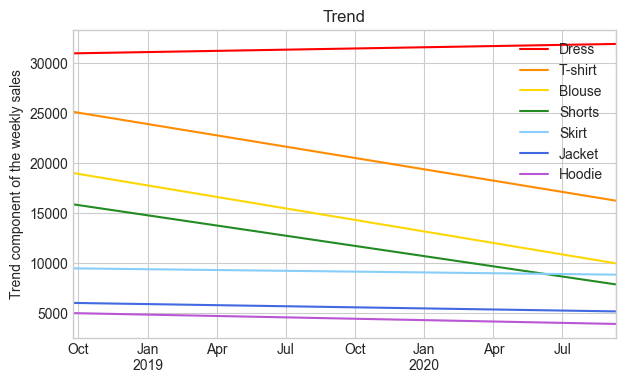

In [16]:
fig,ax = plt.subplots(figsize=(7,4))
for i, n in enumerate(sales.columns):
    decomp_products[i].trend.plot(ax=ax, color=colors[i],label=n)
    
plt.xlabel('')
plt.ylabel('Trend component of the weekly sales')
plt.title('Trend')
plt.legend()
plt.show()

In [17]:
### Uncomment block to plot the product weekly sales time-series with the trend component subtracted.

# fig,ax = plt.subplots(figsize=(7,4))
# for i, n in enumerate(sales.columns):
#     (decomp_products[i].observed - decomp_products[i].trend).plot(ax=ax, color=colors[i],label=n)
    
# plt.xlabel('')
# plt.ylabel('Weekly sales without trend')
# plt.title('Oberserved without trend')
# plt.legend()
# plt.show()

In [18]:
### Uncomment block to plot all the product weekly sales time-series separately, in one figure.

# fig,ax = plt.subplots(figsize=(15,5))
# sales.plot(ax=ax,marker='o',ms=2.5,color=colors)

# for m in np.arange(1,104, 4):    
#     plt.axvline(sales.index[m],color='gainsboro',linestyle=':',zorder=1)
# ax.xaxis.grid(False) 
# plt.xlabel('')
# plt.ylabel('Number of weekly sales')
# plt.title('')
# plt.legend(fontsize=16)
# plt.show()

> **b. Are there correlations between sales of some product types, and if so, which?**

In [19]:
# using pandas
corr_matrix = sales.corr() # default is pearson
print("Correlation matrix:")
round(corr_matrix,2)

Correlation matrix:


,Dress,T-shirt,Blouse,Shorts,Skirt,Jacket,Hoodie
Dress,1.00,0.83,0.69,0.91,0.93,-0.43,-0.51
T-shirt,0.83,1.00,0.79,0.86,0.78,-0.33,-0.43
Blouse,0.69,0.79,1.00,0.69,0.77,0.05,-0.04
Shorts,0.91,0.86,0.69,1.00,0.83,-0.56,-0.58
Skirt,0.93,0.78,0.77,0.83,1.00,-0.20,-0.27
Jacket,-0.43,-0.33,0.05,-0.56,-0.20,1.00,0.90
Hoodie,-0.51,-0.43,-0.04,-0.58,-0.27,0.90,1.00


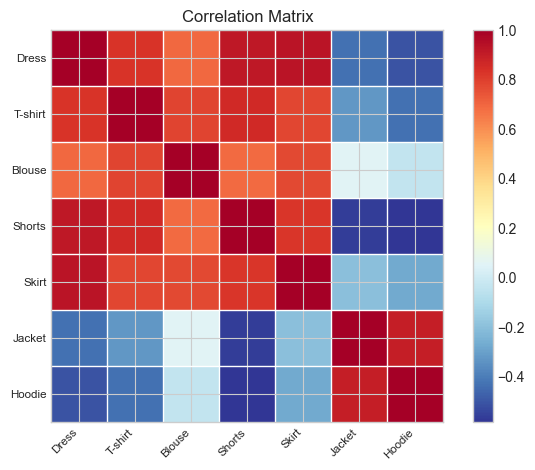

In [20]:
#using statsmodels
import statsmodels.graphics.api as smg

corr_matrix = np.corrcoef(sales.T)
smg.plot_corr(corr_matrix, xnames=sales.columns)
plt.show()

> **c. Select a single product type and make forecast about its sales for 5 time periods (weeks) from the last observed data point. Please include confidence interval of this forecast.**

As the setting for the forecasting model vary with the trend of the time-series, I chose to test the forecast on two different products.   
I will forecast the sales for dresses (linear but not constant trend) and for Skirt (linear almost constant trend).  

In [21]:
# using the ARIMA (Autoregressive Integrated Moving Average) model
# SARIMAX includes a seasonal component
import statsmodels.api as sm
steps = 5

In [22]:
# resampling to have complete cycles, improves estimation
sales_dress = sales['Dress'].resample(sales['Dress'].index.inferred_freq).last() 
model_dress = sm.tsa.SARIMAX(sales_dress, 
                      order=(1,0,0), 
                      seasonal_order=(1,1,1,52), 
                      trend='t', 
                      freq=sales_dress.index.inferred_freq).fit(disp=False)
forecast_dress = model_dress.get_forecast(steps=steps).summary_frame()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


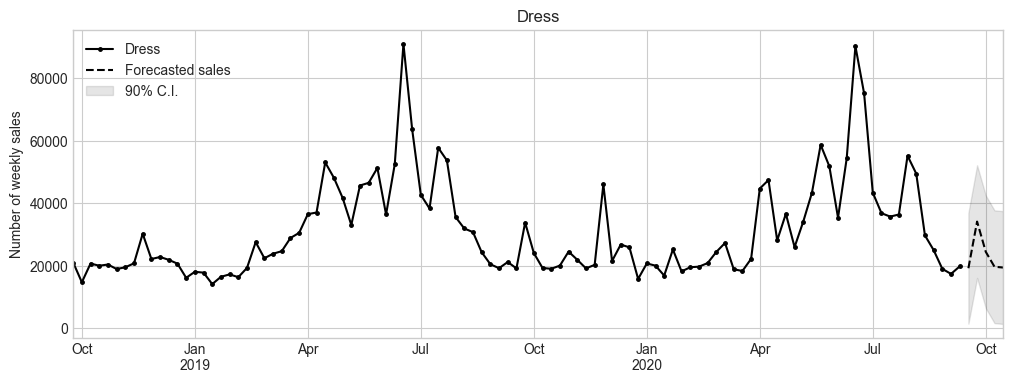

In [23]:
fig,ax = plt.subplots(figsize=(12,4))

sales_dress.plot(ax=ax,marker='o',ms=2.5,color='k')
forecast_dress['mean'].plot(ax=ax, style='k--',label='Forecasted sales')
ax.fill_between(forecast_dress.index, forecast_dress['mean_ci_lower'], forecast_dress['mean_ci_upper'], color='k', alpha=0.1,label='90% C.I.');
    
plt.xlabel('')
plt.ylabel('Number of weekly sales')
plt.title('Dress')
plt.legend(loc='upper left')
plt.show()

In [24]:
# resampling to have complete cycles, improves estimation
sales_skirt = sales['Skirt'].resample(sales['Skirt'].index.inferred_freq).last() 
model_skirt = sm.tsa.SARIMAX(sales_skirt, 
                      order=(1,0,0), 
                      seasonal_order=(1,1,1,52), 
                      trend='c', 
                      freq=sales_skirt.index.inferred_freq).fit(disp=False)
forecast_skirt = model_skirt.get_forecast(steps=steps).summary_frame()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


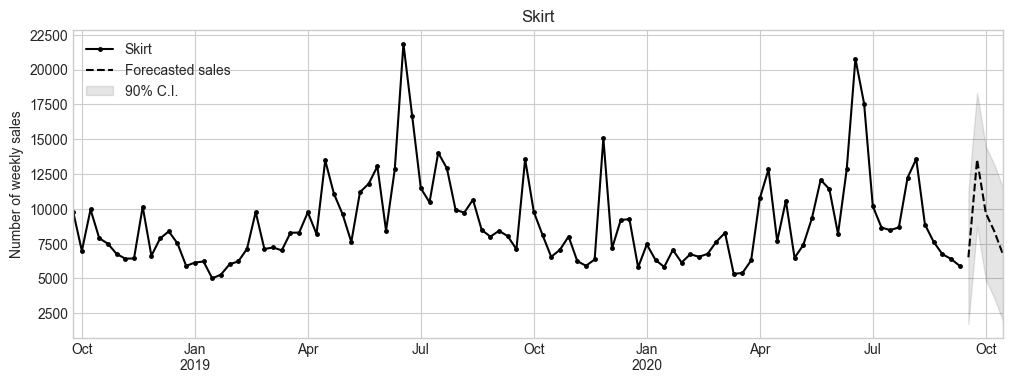

In [25]:
fig,ax = plt.subplots(figsize=(12,4))

sales_skirt.plot(ax=ax,marker='o',ms=2.5,color='k')
forecast_skirt['mean'].plot(ax=ax, style='k--',label='Forecasted sales')
ax.fill_between(forecast_skirt.index, forecast_skirt['mean_ci_lower'], forecast_skirt['mean_ci_upper'], color='k', alpha=0.1,label='90% C.I.');
    
plt.xlabel('')
plt.ylabel('Number of weekly sales')
plt.title('Skirt')
plt.legend(loc='upper left')
plt.show()